In [ ]:
import sys
import os

# 패키지 경로 추가 (예: 패키지가 있는 디렉토리)
package_path = os.path.abspath('/home/bjh/dacon/pdf/RAG')
if package_path not in sys.path:
    sys.path.append(package_path)

# 1. layout parser

In [33]:
# pip install -U layoutparser
# pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.1.3#egg=detectron2'

# if "AttributeError: module 'PIL.Image' has no attribute 'LINEAR'" occurs,
# downgrade Pillow under pillow<=9.5.0 or 
# install another version of detectron

In [34]:
import layoutparser as lp
import cv2

model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.7],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

/home/bjh/anaconda3/envs/pymupdf/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_locatio

# 2. Utils

In [35]:
import pymupdf as fitz
import io
import matplotlib.pyplot as plt
from PIL import Image

def pdf_visualize(page, rect, matrix=[4, 4], figsize = (11,15), show=True):

    # 페이지 일부를 이미지로 변환
    matrix = fitz.Matrix(*matrix) # 해상도 높이기
    pix = page.get_pixmap(clip=rect, matrix=matrix)

    # 이미지 데이터를 PIL 이미지로 변환
    img = Image.open(io.BytesIO(pix.tobytes()))

    # 이미지를 Jupyter Notebook에서 바로 표시
    if show:
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.axis('off')  # 축 숨기기
        plt.show()

    return pix


In [36]:
# ----------------------------------------------------------------
# 문서의 vector graphic의 데이터를 기반으로 수평선을 찾는 함수입니다.
# ----------------------------------------------------------------
def get_horizontal_lines(page:fitz.Page, rect:fitz.Rect):
    shapes = page.get_drawings()

    # 수평선 필터링
    horizontal_lines = []
    for shape in shapes:
        for item in shape["items"]:
            if item[0] == "l":  # "l" indicates a line
                x0, y0 = item[1]
                x1, y1 = item[2]
                if y0 == y1:  # y좌표가 같으면 수평선
                    line_rect = fitz.Rect(x0, y0, x1, y1)
                    if rect.contains(item[1]) and rect.contains(item[2]): # clip_rect.include_rect(line_rect)
                        line = fitz.Rect(int(x0), int(y0), int(x1), int(y1))
                        horizontal_lines.append(line)
                        # print(f"수평선 좌표: {x0}, {y0} -> {x1}, {y1}")
                        # page.draw_line(item[1], item[2], color=(1, 0, 0))

    return horizontal_lines

# ----------------------------------------------------------------
# vector graphic의 수평선을 기반으로 그릴 수 있는 수직선 찾기. 
# ----------------------------------------------------------------
def get_vertical_lines(page:fitz.Page, table_rec:fitz.Rect, horizontal_lines):
    horizontal_lines.sort(key=lambda i: abs(i), reverse=True)
    # run from back to front (= small to large)
    for i in range(len(horizontal_lines) - 1, 0, -1):
        img1 = horizontal_lines[i]
        img0 = horizontal_lines[i - 1]
        if (
            fitz.Rect(img1) & page.rect
            in fitz.Rect(img0) & page.rect
        ):
            del horizontal_lines[i]  # contained in some larger image

    work = {i:line for i, line in enumerate(horizontal_lines)}
    vertical_lines = []
    i = 0
    while len(work) > 0:
        rec = work.pop(i, None)
        if rec is not None:
            x1, y1, x2, y2 = rec
            y_min = table_rec[1]
            y_max = table_rec[3]

            for _i in range(i-1, 0, -1):
                h = horizontal_lines[_i]
                if h[0] < x1:
                    y_min = h[1]
                    break

            for _i, h in enumerate(horizontal_lines[i+1:]):
                if h[0] < x1:
                    y_max = h[1]
                    break
                elif h[0] == x1:
                    del work[i+_i+1]

            vertical_lines.append([(x1, y_min), (x1, y_max)])

        i += 1

    return vertical_lines

# ----------------------------------------------------------------
# table 의 글자 위치를 기반으로 그릴 수 있는 수직선 찾기 
# ----------------------------------------------------------------
def get_interval_vertical_lines(page:fitz.Page, table_rec:fitz.Rect):
    table_blocks = page.get_text("dict", clip=table_rec)["blocks"]
    table_spans = [span for block in table_blocks for line in block.setdefault('lines', []) for span in line.setdefault('spans', [])]

    table_spans.sort(key=lambda s: [s["bbox"][0], s["bbox"][1]])

    def intersect_(pp1, pp2):
        p1, p2 = pp1[:], pp2[:]
        if p1[0] > p2[0]: p1, p2 = p2, p1

        if p1[1] > p2[0]:
            return True, (p1[0], max(p2[1], p1[1]))
        else:
            return False, (None, None)

    def union(intervals):
        i = 0
        while i < len(intervals)-1:
            p1, p2 = intervals[i], intervals[i+1]
            flag, (x1_new, x2_new) = intersect_(p1, p2)
            if flag:
                intervals.remove(p1); intervals.remove(p2)
                intervals.insert(i, (x1_new, x2_new))
            else:
                i += 1


    def intersect(point, intervals):
        prev = (-1, -1)
        for index, point2 in enumerate(intervals):
            flag, (x1_new, x2_new) = intersect_(point, point2)
            if flag:
                point2[0] = x1_new
                point2[1] = x2_new
                union(intervals)
                return True, None
            else:
                if prev[1] < point[0] and point[1] < point2[0]:
                    return False, index
            prev = point2
        return False, len(intervals)


    intervals = []
    for span in table_spans:
        x1, _, x2, _ = span['bbox']
        flag, index = intersect([x1, x2], intervals)
        if not flag:
            intervals.insert(index, [x1, x2])

    vertical_line_x = [intervals[0][0]-2]
    interval_len = len(intervals)
    for i in range(interval_len-1):
        x1, x2 = intervals[i][1], intervals[i+1][0]
        vertical_line_x.append((x1+ x2)/2)
    vertical_line_x.append(intervals[-1][1]+2)

    x1, y1, x2, y2 = table_rec
    return [[(x, y1), (x, y2)] for x  in vertical_line_x]

# ----------------------------------------------------------------
# 테이블의 셀을 인식할 수 있도록 vector graphic 기반으로 
# 테이블 선을 인식하는 함수
# return -> guidelines:list [[(x1, y1), (x2, y2)], ...] 
# x, y:float
# ----------------------------------------------------------------
def get_table_guidelines(page, table_rec):
    margin = fitz.Rect(-5, -5, 5, 5)

    horizontal_lines = get_horizontal_lines(page, table_rec+margin)
    horizontal_lines_ = [[(l[0], l[1]), (l[2], l[3])] for l in horizontal_lines]
    vertical_lines = get_vertical_lines(page, table_rec, horizontal_lines)
    interval_vertical_lines = get_interval_vertical_lines(page, table_rec)

    x1, y1, x2, y2 = table_rec
    table_edgs = [
        [(x1, y1), (x1, y2)],
        [(x1, y1), (x2, y1)],
        [(x1, y2), (x2, y2)],
        [(x2, y1), (x2, y2)],
    ]
    guidelines = horizontal_lines_ + table_edgs + vertical_lines + interval_vertical_lines 

    return guidelines




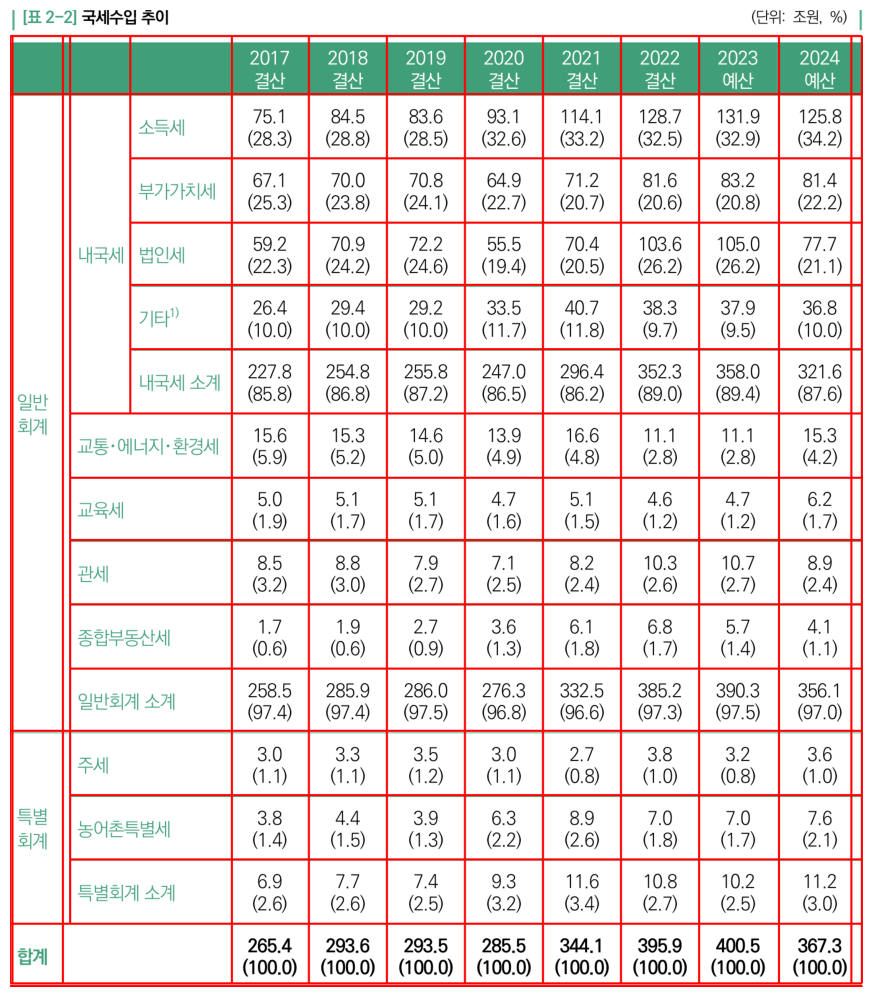

Pixmap(DeviceRGB, (316, 676, 1961, 2562), 0)

In [37]:
doc_path, pno = "./train_source/1-1 2024 주요 재정통계 1권.pdf", 31
doc = fitz.Document(doc_path)
page = doc.load_page(pno)
rect = fitz.Rect(75, 175., 495., 643.)
table_rec = fitz.Rect(79.09590911865234, 182.02479553222656, 489.72882080078125, 638.7496337890625)

add_lines = get_table_guidelines(page, table_rec)

# 추가된 선을 페이지에 그리기
for line in add_lines:
    start, end = line
    page.draw_line(start, end, color=(1, 0, 0))  # 빨간색 선

pdf_visualize(page, (79.11897277832031, 169.1558074951172, 490.1029357910156, 640.4242553710938), matrix=[4, 4], figsize = (11,16), show=True)


In [ ]:
# import pymupdf4llm

# table = pymupdf4llm.to_markdown(doc, pages=[31])
# print(table)

|Col1|Col2|Col3|Col4|2017 결산|2018 결산|2019 결산|2020 결산|2021 결산|2022 결산|2023 예산|2024 예산|Col13|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|일반 회계||내국세|소득세|75.1 (28.3)|84.5 (28.8)|83.6 (28.5)|93.1 (32.6)|114.1 (33.2)|128.7 (32.5)|131.9 (32.9)|125.8 (34.2)||
||||부가가치세|67.1 (25.3)|70.0 (23.8)|70.8 (24.1)|64.9 (22.7)|71.2 (20.7)|81.6 (20.6)|83.2 (20.8)|81.4 (22.2)||
||||법인세|59.2 (22.3)|70.9 (24.2)|72.2 (24.6)|55.5 (19.4)|70.4 (20.5)|103.6 (26.2)|105.0 (26.2)|77.7 (21.1)||
||||기타1)|26.4 (10.0)|29.4 (10.0)|29.2 (10.0)|33.5 (11.7)|40.7 (11.8)|38.3 (9.7)|37.9 (9.5)|36.8 (10.0)||
||||내국세 소계|227.8 (85.8)|254.8 (86.8)|255.8 (87.2)|247.0 (86.5)|296.4 (86.2)|352.3 (89.0)|358.0 (89.4)|321.6 (87.6)||
|||교통･에너지･환경세||15.6 (5.9)|15.3 (5.2)|14.6 (5.0)|13.9 (4.9)|16.6 (4.8)|11.1 (2.8)|11.1 (2.8)|15.3 (4.2)||
|||교육세||5.0 (1.9)|5.1 (1.7)|5.1 (1.7)|4.7 (1.6)|5.1 (1.5)|4.6 (1.2)|4.7 (1.2)|6.2 (1.7)||
|||관세||8.5 (3.2)|8.8 (3.0)|7.9 (2.7)|7.1 (2.5)|8.2 (2.4)|10.3 (2.6)|10.7 (2.7)|8.9 (2.4)||
|||종합부동산세||1.7 (0.6)|1.9 (0.6)|2.7 (0.9)|3.6 (1.3)|6.1 (1.8)|6.8 (1.7)|5.7 (1.4)|4.1 (1.1)||
|||일반회계 소계||258.5 (97.4)|285.9 (97.4)|286.0 (97.5)|276.3 (96.8)|332.5 (96.6)|385.2 (97.3)|390.3 (97.5)|356.1 (97.0)||
|특별 회계||주세||3.0 (1.1)|3.3 (1.1)|3.5 (1.2)|3.0 (1.1)|2.7 (0.8)|3.8 (1.0)|3.2 (0.8)|3.6 (1.0)||
|||농어촌특별세||3.8 (1.4)|4.4 (1.5)|3.9 (1.3)|6.3 (2.2)|8.9 (2.6)|7.0 (1.8)|7.0 (1.7)|7.6 (2.1)||
|||특별회계 소계||6.9 (2.6)|7.7 (2.6)|7.4 (2.5)|9.3 (3.2)|11.6 (3.4)|10.8 (2.7)|10.2 (2.5)|11.2 (3.0)||
|합계||||265.4 (100.0)|293.6 (100.0)|293.5 (100.0)|285.5 (100.0)|344.1 (100.0)|395.9 (100.0)|400.5 (100.0)|367.3 (100.0)||

위 결과를 보면 가이드 라인이 없는 표와 달리 제대로 인식한 것을 볼 수 있다.   
위 get_table_guidelines 함수에 필요한 건 테이블 영역 위치인 table_rec  
이건 layoutparser로 구할 수 있다. 
 